# 重构“策略”模式
在使用将函数视为一等对象的语言时，可以将涉及使用某些接口的实例（实现类的实例）方法时，改用更简单的函数对象，从而较少或去除样板类（接口、抽象类）代码。
# 策略模式
#### 定义：定义一系列算法把它们一一封装起来，并且使他们可以相互替换。
## 电商领域示例-折扣策略
上下文：主流程，其中的计算折扣策略委托给不同的算法可替换组件，使其与具体折扣解耦。本例中上下文就是"Order"。  
策略：实现不同折扣算法的共同接口定义，在此为Promotion抽象类。  
具体策略：Promotion实现子类。
### 模式思想
Order的折扣实现时对Promotion具体子类实例的调用，通过定义的Promotion接口可实现折扣策略的模块化切换。具体实现上，Promotion子类可接收Order类对象作为信息获取的载体，从而计算出折扣金额。
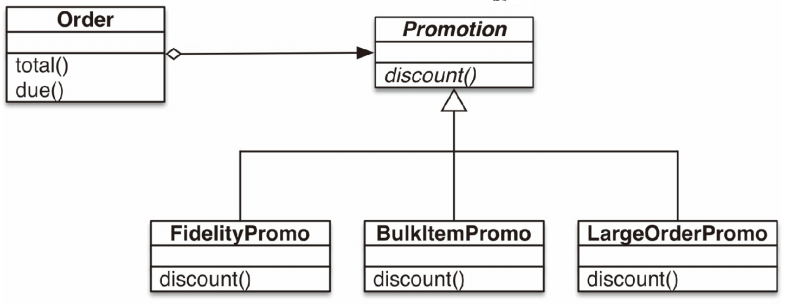

In [7]:
from abc import ABC,abstractclassmethod
from collections import namedtuple

Customer = namedtuple("Customer", "name fidelity")

class LineItem:
    def __init__(self, product, quantity, price):
        self.product = product
        self.quantity = quantity
        self.price = price
    
    def total(self):
        return self.quantity * self.price
    
class Order:
    def __init__(self, customer, cart, promotion=None):
        self.customer = customer
        self.cart = list(cart)
        self.promotion = promotion
        
    def total(self):
        if not hasattr(self, "__total"):
            self.__total = sum(item.total() for item in self.cart)
            return self.__total
        
    def due(self):
        if self.promotion is None:
            discount = 0
        else:
            discount = self.promotion.discount(self)
        return self.total() - discount
    
    def __repr__(self):
        return '<Order total:{%.2f} due:{%.2f}>' % (self.total(), self.due())
    
class Promotion(ABC):
    @abstractclassmethod
    def discount(self, order):
        """返回折扣金额"""
        
class FidelityPromo(Promotion):
    """为积分>=1000的顾客提供5%折扣"""
    def discount(self, order):
        return order.total() * 0.05 if order.customer.fidelity >= 1000 else 0
        
class BulkItemPromo(Promotion):
    """为当个商品数量>=20的顾客提供10%折扣"""
    def discount(self, order):
        dicount = 0
        for item in order.cart:
            if item.quantity >= 20:
                discount += item.total() * 0.1
        return discount
    
class LargeOrderPromo(Promotion):
    """为订单中商品种类>=10的顾客提供7%折扣"""
    def discount(self, order):
        if len(set(item.product for item in order.cart)) >= 10:
            return order.total() * 0.07
        return 0

In [10]:
joe = Customer('John Doe', 0)
ann = Customer('Ann Smith', 1100)
cart = (LineItem('banana', 4, 0.5), LineItem('apple', 10, 1.5),LineItem('watermellon', 5, 5.0))
print(Order(joe, cart, FidelityPromo())) # 使用积分折扣方案
print(Order(ann, cart, FidelityPromo()))

<Order total:{42.00} due:{42.00}>
<Order total:{42.00} due:{39.90}>


# 使用一等函数改进策略模式
在策略模式中，策略是享元，策略对象可以仅创建一次然后不断复用，但这里的策略因为无需维护内部状态因此可用函数来代替，这样一来能节省资源。
#### 上面每个具体策略都是只定义了一个方法的类，因此可以用函数代替，因为从函数的角度来看，它们都是实现了\__call__协议的function类的可调用对象（对象创建时属性不同，调用时表现出来就像在使用不同的方法）。

In [12]:
from abc import ABC,abstractclassmethod
from collections import namedtuple

Customer = namedtuple("Customer", "name fidelity")

class LineItem:
    def __init__(self, product, quantity, price):
        self.product = product
        self.quantity = quantity
        self.price = price
    
    def total(self):
        return self.quantity * self.price
    
class Order:
    def __init__(self, customer, cart, promotion=None):
        self.customer = customer
        self.cart = list(cart)
        self.promotion = promotion
        
    def total(self):
        if not hasattr(self, "__total"):
            self.__total = sum(item.total() for item in self.cart)
            return self.__total
        
    def due(self):
        if self.promotion is None:
            discount = 0
        else:
            discount = self.promotion(self)
        return self.total() - discount
    
    def __repr__(self):
        return '<Order total:{%.2f} due:{%.2f}>' % (self.total(), self.due())
        
def fidelity_promo(order):
    """为积分>=1000的顾客提供5%折扣"""
    return order.total() * 0.05 if order.customer.fidelity >= 1000 else 0
        
def bulkItem_promo(order):
    """为当个商品数量>=20的顾客提供10%折扣"""
    dicount = 0
    for item in order.cart:
        if item.quantity >= 20:
            discount += item.total() * 0.1
    return discount
    
def largeOrder_promo(order):
    """为订单中商品种类>=10的顾客提供7%折扣"""
    if len(set(item.product for item in order.cart)) >= 10:
        return order.total() * 0.07
    return 0

In [13]:
joe = Customer('John Doe', 0)
ann = Customer('Ann Smith', 1100)
cart = (LineItem('banana', 4, 0.5), LineItem('apple', 10, 1.5),LineItem('watermellon', 5, 5.0))
print(Order(joe, cart, fidelity_promo)) # 使用积分折扣方案
print(Order(ann, cart, fidelity_promo))

<Order total:{42.00} due:{42.00}>
<Order total:{42.00} due:{39.90}>


# 选择最佳策略
选择最佳策略的实现很简单，仅需遍历全部策略选择折扣最优的即可，但是我们需要维护一个包含全部可选策略的序列，如果没有某种自动化机制仅靠人工构造一个列表变量，那么很容易出错且繁琐。此时可以使用内省以自动创建该列表，内省的方式可使用如下几种。  
__globals()__:表示当前模块定义的全局符号表。  
__inspect.getmembers()__:用于获取对象的属性，由于模块也是对象，因此可获取其定义的全部属性。该高阶方法接受模块对象和过滤函数。  
__装饰器__:

In [ ]:
import inspect
import promotions
promos = [globals()[name] for name in globals() if name.endswith('_promo') and name != 'best_promo']
promos = [func for name, func in inspect.getmembers(promotions, inspect.isfunction)] # promotions模块内的函数只能是策略函数。
def best_promo(order):
    """返回最佳折扣"""
    return max(promo(order) for promo in promos)

# 命令模式
如图所示，命令模式的目的在于将命令的调用者同命令的接受者（实现者）解耦，命令调用者只需要调用命令对象的标准api（接口定义，同时命令对象需要持有命令实现者对象以完成具体实现流程）而无需了解命令接受者的具体接口和执行逻辑。
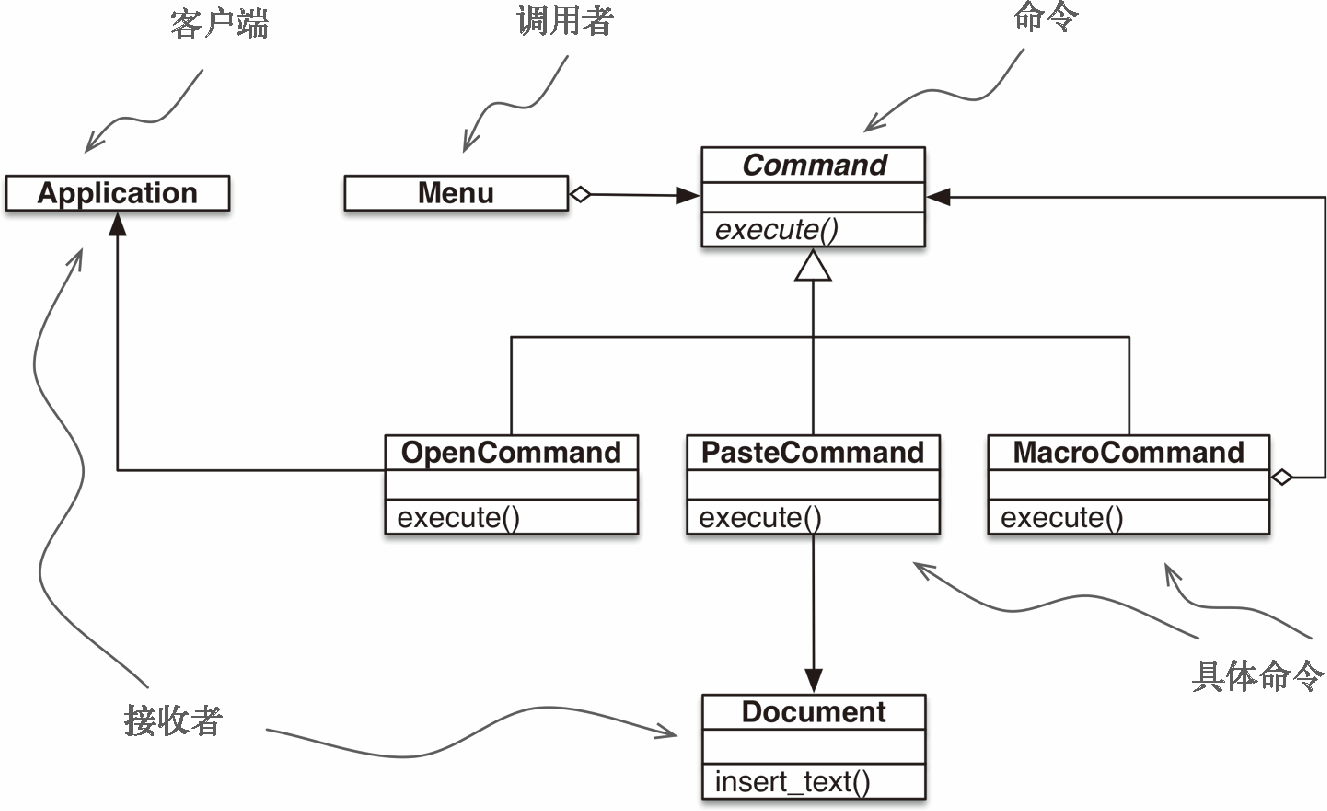
对于Command来说无需维护状态仅需要实现一个execute方法，因此可以用函数代替即可，另外一方面对于MacroCommand来说，其含义为保存一组Command来执行，因此仅仅使用函数是不够的，此时可以把它设计为实现\__call__的类的可调用实例，其内部维护需要调用的函数序列即可。
### 这里相当于把需要实现单方法同时又需要其他额外状态或功能的的子类实例替换为可调用对象（实现了\__call__协议）。

In [18]:
class MacroCommand:
    """执行一组命令函数的命令"""
    def __init__(self, commands):
        self.commands = commands
    
    def __call__(self):
        for command in self.commands:
            command()